# Presence in Brasilia while eating far away

The `reimbursements.xz` dataset includes meal expenses, not allowed for anyone other than congresspeople. Thus, if we could find meal expenses made far away from Brasilia while the congressperson attended a congressional session, we can consider this as a suspicious expense. Possibly an entry mistake or just that the politician was in Brasilia or eating the meal, but not both at the same time.

In [1]:
from serenata_toolbox.datasets import fetch

# fetch('2016-12-21-presences.xz', '../data')
# fetch('2016-12-21-sessions.xz', '../data')

In [2]:
import numpy as np
import pandas as pd

presences = pd.read_csv('../data/2016-12-21-presences.xz')
print(presences.shape)
presences.head()

(188227, 5)


,date,registration,congressperson_name,session,presence
0,2015-02-01 10:33:09,361,Goulart-PSD/SP,SESSÃO PREPARATÓRIA Nº 001 - 01/02/2015,Presença
1,2015-02-01 10:33:09,361,Goulart-PSD/SP,SESSÃO PREPARATÓRIA Nº 002 - 01/02/2015,Presença
2,2015-02-03 08:00:00,361,Goulart-PSD/SP,ORDINÁRIA Nº 001 - 03/02/2015,Presença
3,2015-02-03 08:00:00,361,Goulart-PSD/SP,EXTRAORDINÁRIA Nº 002 - 03/02/2015,Presença
4,2015-02-04 08:00:01,361,Goulart-PSD/SP,ORDINÁRIA Nº 003 - 04/02/2015,Presença


In [3]:
presences['congressperson_name'] = presences['congressperson_name'] \
    .apply(lambda name: '-'.join(name.split('-')[:-1]))

In [4]:
sessions = pd.read_csv('../data/2016-12-21-sessions.xz')
print(sessions.shape)
sessions.head()

(405, 3)


,date,description,started_at
0,2015-02-01,SESSÃO PREPARATÓRIA Nº 001 - 01/02/2015,2015-02-01 11:26:01
1,2015-02-01,SESSÃO PREPARATÓRIA Nº 002 - 01/02/2015,2015-02-01 17:57:28
2,2015-02-03,ORDINÁRIA Nº 001 - 03/02/2015,2015-02-03 14:00:12
3,2015-02-03,EXTRAORDINÁRIA Nº 002 - 03/02/2015,2015-02-03 19:03:02
4,2015-02-04,ORDINÁRIA Nº 003 - 04/02/2015,2015-02-04 14:00:07


## Duration of each session

By checking the Chamber of Deputies website[1], we can find out the duration of each session (except for the cases when there aren't enough congresspeople to attend).

[1]: http://www2.camara.leg.br/comunicacao/assessoria-de-imprensa/sessoes-do-plenario

In [5]:
presences['session'].apply(lambda value: value.split(r' Nº')[0]).unique()

array(['SESSÃO PREPARATÓRIA', 'ORDINÁRIA', 'EXTRAORDINÁRIA',
       'EXTRAORDINÁRIA 166 - 23/06/2015', 'ORDINÁRIA 168 - 24/06/2015',
       'EXTRAORDINÁRIA 169- 24/06/2015', 'EXTRAORDINÁRIA 170 - 25/06/2015',
       'EXTRAORDINÁRIA 171 - 25/06/2015'], dtype=object)

In [6]:
def duration_in_hours(description):
    if 'EXTRAORDINÁRIA' in description:
        return 4
    elif 'ORDINÁRIA' in description:
        return 5



presences['duration'] = presences['session'].apply(duration_in_hours)
presences['duration'].head()

0    NaN
1    NaN
2    5.0
3    4.0
4    5.0
Name: duration, dtype: float64

In [7]:
presences_wo_duration = presences['duration'].isnull().sum()
presences_wo_duration, presences_wo_duration / len(presences['duration'])

(956, 0.0050789737922827226)

## Presences

In [8]:
presences['presence'].unique()

array(['Presença', 'Ausência'], dtype=object)

Curious to know if there's a pattern between presence in the Congress and suspicious meals. Could exist any relationship between percentage of attendance in sessions and these irregularities?

In [9]:
import matplotlib

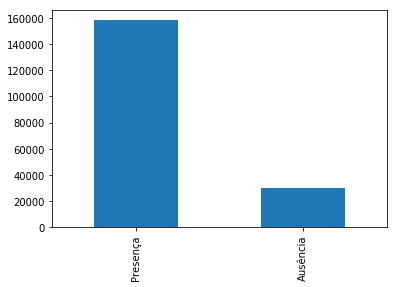

In [10]:
%matplotlib inline

presences['presence'].value_counts().plot(kind='bar')

In [11]:
presences.head()

,date,registration,congressperson_name,session,presence,duration
0,2015-02-01 10:33:09,361,Goulart,SESSÃO PREPARATÓRIA Nº 001 - 01/02/2015,Presença,NaN
1,2015-02-01 10:33:09,361,Goulart,SESSÃO PREPARATÓRIA Nº 002 - 01/02/2015,Presença,NaN
2,2015-02-03 08:00:00,361,Goulart,ORDINÁRIA Nº 001 - 03/02/2015,Presença,5.0
3,2015-02-03 08:00:00,361,Goulart,EXTRAORDINÁRIA Nº 002 - 03/02/2015,Presença,4.0
4,2015-02-04 08:00:01,361,Goulart,ORDINÁRIA Nº 003 - 04/02/2015,Presença,5.0


Let's find out the attendance level of each congressperson.

In [12]:
attendence = presences.query('presence == "Presença"').groupby('registration')['session'].count().reset_index()
absence = presences.query('presence == "Ausência"').groupby('registration')['session'].count().reset_index()
attendence = attendence.merge(absence, on='registration')
attendence.rename(columns={'session_x': 'presence', 'session_y': 'absence'}, inplace=True)
attendence['attendence'] = attendence['presence'] / (attendence['absence'] + attendence['presence'])
attendence.sort_values('attendence', inplace=True)
print(attendence.shape)

(477, 4)


In [13]:
attendence = attendence.merge(presences[['congressperson_name', 'registration']].drop_duplicates())
attendence.head(10)

,registration,presence,absence,attendence,congressperson_name
0,23,123,282,0.303704,Wladimir Costa
1,71,13,19,0.406250,Julião Amin Castro
2,373,199,206,0.491358,Paulo Maluf
3,87,184,154,0.544379,Aníbal Gomes
4,16,224,181,0.553086,Vinicius Gurgel
5,469,226,179,0.558025,Takayama
6,11,226,179,0.558025,Jozi Rocha
7,446,184,144,0.560976,Edmar Arruda
8,321,238,167,0.587654,Marcos Soares
9,348,243,162,0.600000,Guilherme Mussi


Now, we can group by day and find out how many sessions and hours had the congressperson attendance.

In [14]:
presence_overview = presences.query('presence == "Presença"')
days = presence_overview['date'].apply(lambda value: value.split(' ')[0])
presence_overview['day'] = pd.to_datetime(days)
presence_overview = presence_overview \
    .groupby(['registration', 'day'])['duration'] \
    .agg([len, np.sum]) \
    .rename(columns={'len': 'sessions', 'sum': 'duration'}) \
    .reset_index()
presence_overview.sort_values('sessions', ascending=False).head()

/Users/irio/anaconda3/envs/serenata_de_amor/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,registration,day,sessions,duration
38891,226,2016-04-16,5.0,20.0
67866,387,2016-04-16,5.0,20.0
78599,447,2016-04-16,5.0,20.0
43153,248,2016-04-16,5.0,20.0
67668,386,2016-04-16,5.0,20.0


**Sessions per day (when greater than zero)**

(array([ 36868.,      0.,  42423.,      0.,      0.,   9097.,      0.,
          2098.,      0.,    149.]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

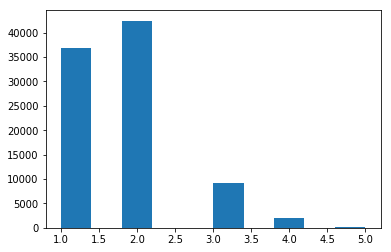

In [15]:
import matplotlib.pyplot as plt

plt.hist(presence_overview['sessions'])

**Work hours per day (when greater than zero)**

(array([ 36832.,      0.,  17776.,  24205.,      0.,   9097.,      0.,
          1800.,    298.,    149.]),
 array([  4. ,   5.6,   7.2,   8.8,  10.4,  12. ,  13.6,  15.2,  16.8,
         18.4,  20. ]),
 <a list of 10 Patch objects>)

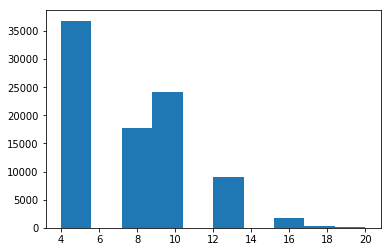

In [16]:
non_null_duration_per_day = presence_overview['duration'][presence_overview['duration'].notnull()]
plt.hist(non_null_duration_per_day)

Load `reimburments.xz` to merge with `presence_overview`.

In [17]:
reimbursements = pd.read_csv('../data/2017-03-15-reimbursements.xz',
                             dtype={'cnpj_cpf': np.str},
                             low_memory=False)
reimbursements['issue_date'] = pd.to_datetime(reimbursements['issue_date'], errors='coerce')

companies = pd.read_csv('../data/2016-09-03-companies.xz', low_memory=False)
companies['cnpj'] = companies['cnpj'].str.replace(r'\D', '')

In [18]:
reimbursements = reimbursements.merge(companies, left_on='cnpj_cpf', right_on='cnpj')

To find out how to properly merge `presences` with `reimbursements`, we need to find a common column. `congressperson_name` could be used, but an ID would be better.

In [19]:
presences.drop_duplicates('registration').query('congressperson_name == "Takayama"')

,date,registration,congressperson_name,session,presence,duration
19293,2015-02-01 10:33:09,469,Takayama,SESSÃO PREPARATÓRIA Nº 001 - 01/02/2015,Presença,NaN


In [20]:
reimbursements.query('congressperson_name == "TAKAYAMA"').iloc[0, :10]

year                             2009
applicant_id                     1693
document_id                   1576214
reimbursement_value_total         NaN
total_net_value                   120
reimbursement_numbers            2912
congressperson_name          TAKAYAMA
congressperson_id               74385
congressperson_document           469
term                             2015
Name: 121, dtype: object

`registration` is the `congressperson_document` in reimbursements.

In [21]:
reimbursements.query('(congressperson_id == 469) | (applicant_id == 469) | (congressperson_document == 469)') \
    [['congressperson_id', 'applicant_id', 'congressperson_document', 'congressperson_name']] \
    .drop_duplicates('congressperson_name')

,congressperson_id,applicant_id,congressperson_document,congressperson_name
121,74385.0,1693,469.0,TAKAYAMA


In [22]:
rows = (reimbursements['subquota_description'] == 'Congressperson meal') & \
            (-73.992222 < reimbursements['longitude']) & (reimbursements['longitude'] < -34.7916667) & \
            (-33.742222 < reimbursements['latitude']) & (reimbursements['latitude'] < 5.2722222) & \
            reimbursements[['congressperson_id', 'latitude', 'longitude']].notnull().all(axis=1)
reimbursements = reimbursements[rows]

In [23]:
reimbursements.shape

(172830, 259)

In [24]:
days_and_congresspeople = presence_overview \
    .rename(columns={'day': 'issue_date', 'registration': 'congressperson_document'}) \
    .merge(reimbursements[['issue_date', 'congressperson_document']])
days_and_congresspeople.head()

,congressperson_document,issue_date,sessions,duration
0,1,2015-10-22,1.0,4.0
1,1,2015-10-29,1.0,4.0
2,1,2015-11-11,3.0,12.0
3,3,2015-02-03,2.0,9.0
4,3,2015-03-31,2.0,9.0


In [25]:
reimbursements = reimbursements.merge(days_and_congresspeople)
reimbursements.drop_duplicates(inplace=True)

In [26]:
reimbursements.query('document_id == 6048825')

,year,applicant_id,document_id,reimbursement_value_total,total_net_value,reimbursement_numbers,congressperson_name,congressperson_id,congressperson_document,term,...,secondary_activity_98_code,secondary_activity_99,secondary_activity_99_code,secondary_activity_9_code,latitude,longitude,latitude.1,longitude.1,sessions,duration
25913,2016,2261,6048825,NaN,34.6,5501,KEIKO OTA,160659.0,356,2015.0,...,NaN,NaN,NaN,NaN,-23.543989,-46.645681,-23.543989,-46.645681,4.0,16.0


In [27]:
AGG_KEYS = ['applicant_id', 'issue_date']

def expenses_centroid(rows):
    return (sum(rows['latitude']) / len(rows['latitude']),
            sum(rows['longitude']) / len(rows['longitude']))

meals_distance_to_congress = reimbursements \
    .groupby(AGG_KEYS) \
    .apply(expenses_centroid) \
    .reset_index() \
    .rename(columns={0: 'meals_centroid'})
meals_distance_to_congress.head()

,applicant_id,issue_date,meals_centroid
0,19,2015-02-05,"(-15.8044535, -47.8949176)"
1,19,2015-03-04,"(-15.8044535, -47.8949176)"
2,19,2015-03-10,"(-15.8044535, -47.8949176)"
3,19,2015-03-17,"(-15.8044535, -47.8949176)"
4,19,2015-03-24,"(-15.8420777, -47.8330014)"


In [28]:
# meals_distance_to_congress['meals_centroid']

In [29]:
from geopy.distance import vincenty as distance

NATIONAL_CONGRESS_LOCATION = -15.7997067, -47.8663516

meals_distance_to_congress['centroid_distance_to_congress'] = meals_distance_to_congress['meals_centroid'] \
    .apply(lambda centroid: distance(NATIONAL_CONGRESS_LOCATION, centroid).km)
reimbursements = reimbursements.merge(meals_distance_to_congress)

In [37]:
reimbursements.shape

(26383, 263)

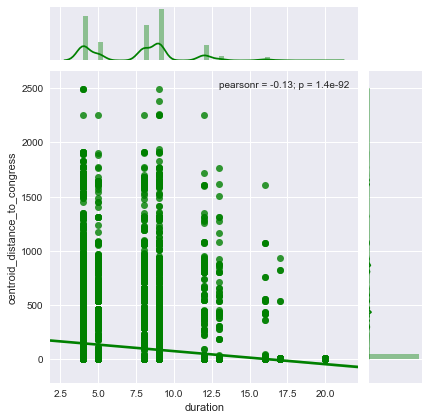

In [36]:
import seaborn as sns

sns.jointplot(data=reimbursements, x='duration', y='centroid_distance_to_congress', kind='reg', color='g')
sns.plt.show()